<a href="https://colab.research.google.com/github/visshal2301/AdvanceSpark_GoogleColab/blob/main/5_Caching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from pyspark.storagelevel import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F

In [3]:
spark = (
    SparkSession
    .builder
    .config("spark.driver.memory", "10g")
    .config("spark.sql.files.maxPartitionBytes", "268435456")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .master("local[*]")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR"
)

In [4]:
customers_file = "/content/drive/MyDrive/data/data_skew/customers.parquet"
df_customers = spark.read.parquet(customers_file)

In [5]:
df_customers.show(5, False)

+----------+-------------+---+------+----------+-----+-----------+
|cust_id   |name         |age|gender|birthday  |zip  |city       |
+----------+-------------+---+------+----------+-----+-----------+
|C007YEYTX9|Aaron Abbott |34 |Female|7/13/1991 |97823|boston     |
|C00B971T1J|Aaron Austin |37 |Female|12/16/2004|30332|chicago    |
|C00WRSJF1Q|Aaron Barnes |29 |Female|3/11/1977 |23451|denver     |
|C01AZWQMF3|Aaron Barrett|31 |Male  |7/9/1998  |46613|los_angeles|
|C01BKUFRHA|Aaron Becker |54 |Male  |11/24/1979|40284|san_diego  |
+----------+-------------+---+------+----------+-----+-----------+
only showing top 5 rows



In [6]:
df_base = (
    df_customers
    .filter(F.col("city") == "boston")
    .withColumn(
        "customer_group",
        F.when(
            F.col("age").between(20, 30),
            F.lit("young")
        )
        .when(
            F.col("age").between(31, 50),
            F.lit("mid")
        )
        .when(
            F.col("age") > 51,
            F.lit("old")
        )
        .otherwise(F.lit("kid"))
     )
    .select("cust_id", "name", "age", "gender", "birthday", "zip", "city", "customer_group")
)

df_base.cache()
df_base.show(5, False)

DataFrame[cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: string]

+----------+--------------+---+------+---------+-----+------+--------------+
|cust_id   |name          |age|gender|birthday |zip  |city  |customer_group|
+----------+--------------+---+------+---------+-----+------+--------------+
|C007YEYTX9|Aaron Abbott  |34 |Female|7/13/1991|97823|boston|mid           |
|C08XAQUY73|Aaron Lambert |54 |Female|11/5/1966|75218|boston|old           |
|C094P1VXF9|Aaron Lindsey |24 |Male  |9/21/1990|29399|boston|young         |
|C097SHE1EF|Aaron Lopez   |22 |Female|4/18/2001|82129|boston|young         |
|C0DTC6436T|Aaron Schwartz|52 |Female|7/9/1962 |57192|boston|old           |
+----------+--------------+---+------+---------+-----+------+--------------+
only showing top 5 rows



In [7]:
df1 = (
    df_base
    .withColumn("test_column_1", F.lit("test_column_1"))
    .withColumn("birth_year", F.split("birthday", "/").getItem(2))
)

df1.explain(True)
df1.show(5, False)

== Parsed Logical Plan ==
'Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1#294, split('birthday, /, -1)[2] AS birth_year#304]
+- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1 AS test_column_1#294]
   +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44]
      +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN old ELSE kid END AS customer_group#44]
         +- Filter (city#6 = boston)
            +- Relation [cust_id#0,name#1,age#2,gender#3,birthday#4,zip#5,city#6] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: st

In [8]:
df2 = (
    df_base
    .withColumn("test_column_2", F.lit("test_column_2"))
    .withColumn("birth_month", F.split("birthday", "/").getItem(1))
)

df2.explain(True)
df2.show(5, False)

== Parsed Logical Plan ==
'Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_2#636, split('birthday, /, -1)[1] AS birth_month#646]
+- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_2 AS test_column_2#636]
   +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44]
      +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN old ELSE kid END AS customer_group#44]
         +- Filter (city#6 = boston)
            +- Relation [cust_id#0,name#1,age#2,gender#3,birthday#4,zip#5,city#6] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: s

**After Caching**

In [9]:
df_base.cache()

DataFrame[cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: string]

In [10]:
df1 = (
    df_base
    .withColumn("test_column_1", F.lit("test_column_1"))
    .withColumn("birth_year", F.split("birthday", "/").getItem(2))
)

df1.explain(True)
df1.show(5, False)

== Parsed Logical Plan ==
'Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1#978, split('birthday, /, -1)[2] AS birth_year#988]
+- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44, test_column_1 AS test_column_1#978]
   +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, customer_group#44]
      +- Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN old ELSE kid END AS customer_group#44]
         +- Filter (city#6 = boston)
            +- Relation [cust_id#0,name#1,age#2,gender#3,birthday#4,zip#5,city#6] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: st

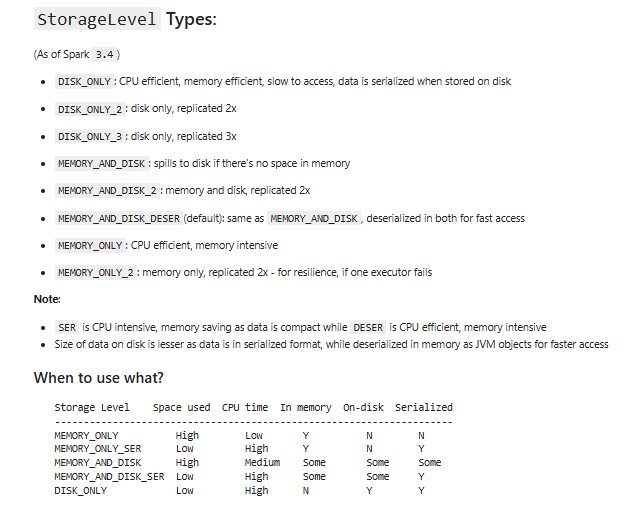

In [11]:
df_base.unpersist()
df_base.persist(StorageLevel.MEMORY_ONLY)

df2 = (
    df_base
    .withColumn("test_column_1", F.lit("test_column_1"))
    .withColumn("birth_year", F.split("birthday", "/").getItem(2))
)

df1.show(5, False)

DataFrame[cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: string]

DataFrame[cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string, customer_group: string]

+----------+--------------+---+------+---------+-----+------+--------------+-------------+----------+
|cust_id   |name          |age|gender|birthday |zip  |city  |customer_group|test_column_1|birth_year|
+----------+--------------+---+------+---------+-----+------+--------------+-------------+----------+
|C007YEYTX9|Aaron Abbott  |34 |Female|7/13/1991|97823|boston|mid           |test_column_1|1991      |
|C08XAQUY73|Aaron Lambert |54 |Female|11/5/1966|75218|boston|old           |test_column_1|1966      |
|C094P1VXF9|Aaron Lindsey |24 |Male  |9/21/1990|29399|boston|young         |test_column_1|1990      |
|C097SHE1EF|Aaron Lopez   |22 |Female|4/18/2001|82129|boston|young         |test_column_1|2001      |
|C0DTC6436T|Aaron Schwartz|52 |Female|7/9/1962 |57192|boston|old           |test_column_1|1962      |
+----------+--------------+---+------+---------+-----+------+--------------+-------------+----------+
only showing top 5 rows



In [12]:
spark.stop()